# Experiment Analysis

In [1]:
# Imports:

import os
import sys

sys.path.append(os.path.join("..", "code"))

from experiment_analysis import *
from experiments import *

In [2]:
exp_analysis = ExperimentAnalysis()

In [3]:
# Run this cell to compute results for new experiments (takes a long time):
results = exp_analysis.compute_results()

100%|██████████| 157/157 [01:17<00:00,  2.03it/s]

Results saved to:
  /tf/toby/discharge-estimation/models/../experiments/experiment_results.csv


In [4]:
# results = exp_analysis.results

### Gage 11402000 results

In [5]:
single_gage_results = results[results["gages"] == "['11402000']"]

#### Best RMSE model

dae2bad4-9b12-4c79-bb26-1c7fddda9fc3
283


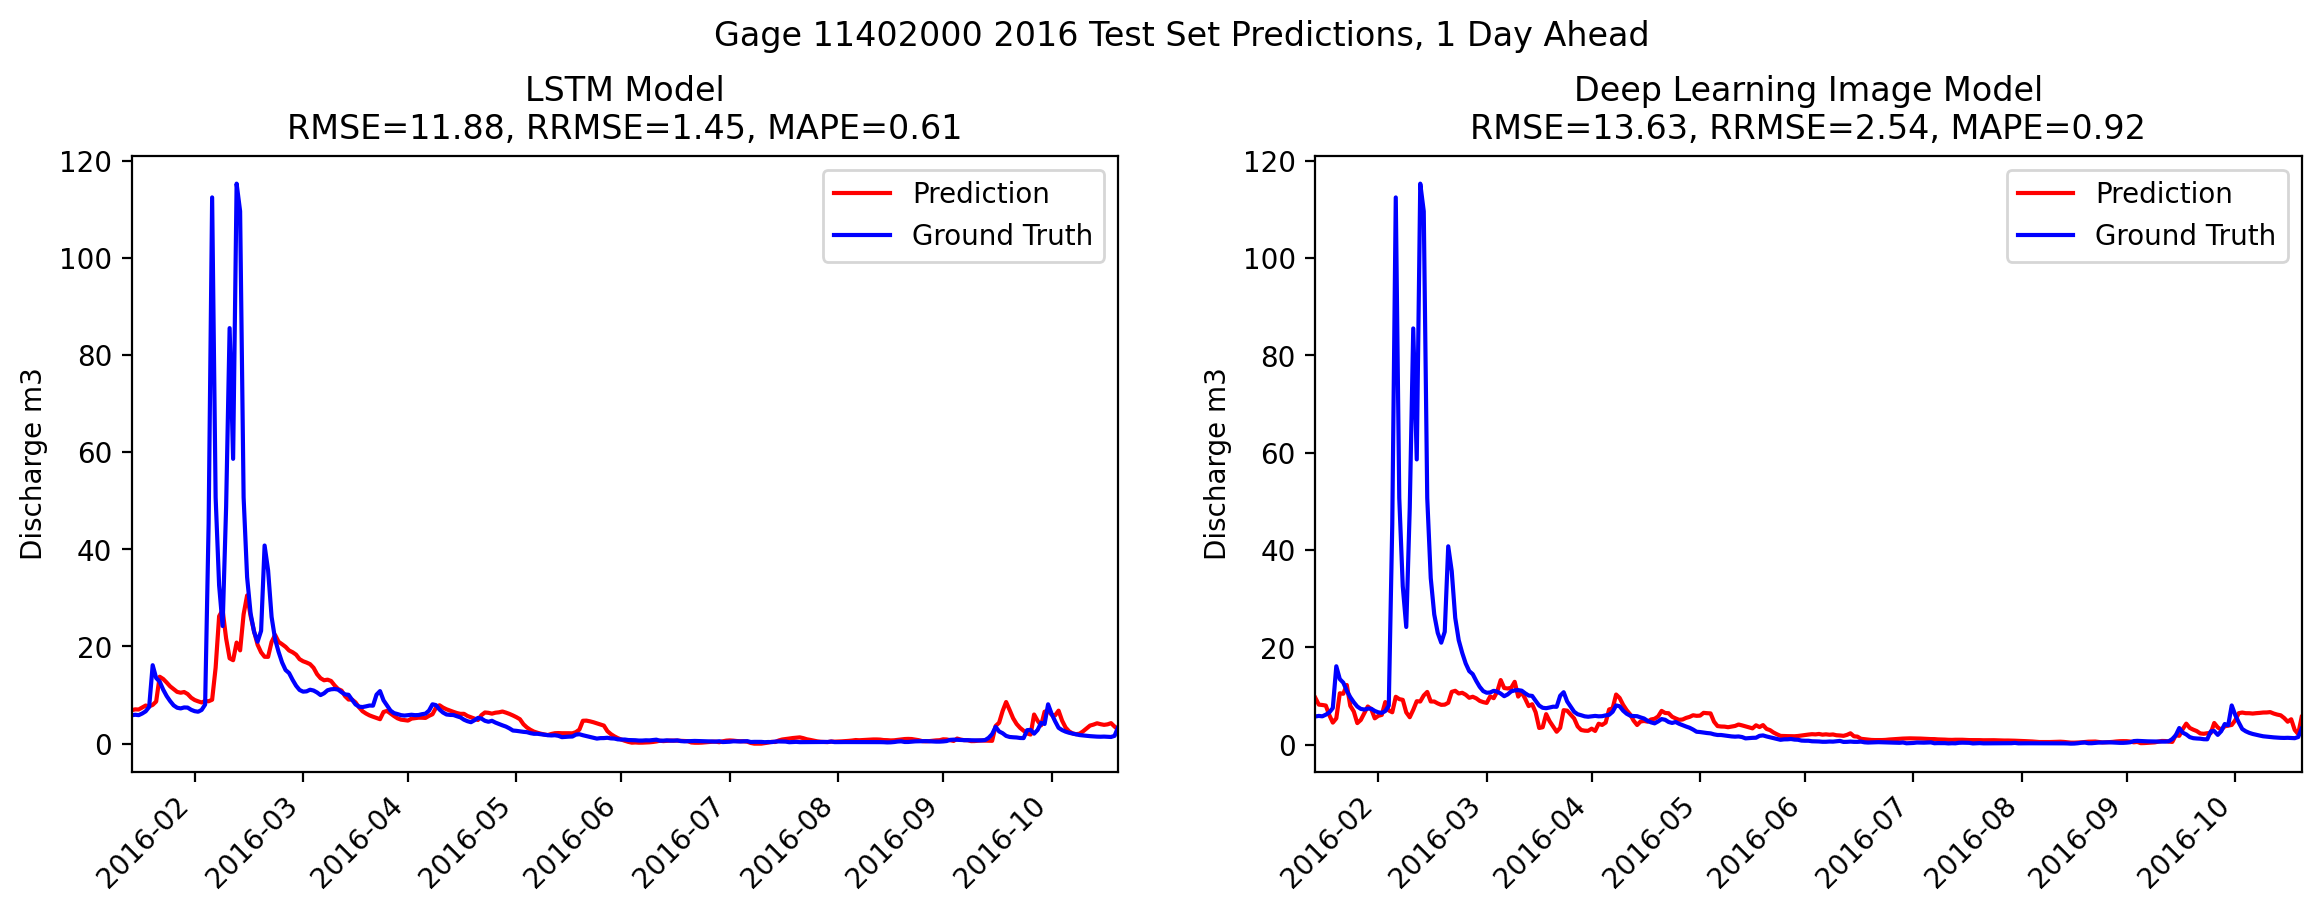

In [6]:
day = 1

sorted_results = single_gage_results.sort_values(by=[f"rmse_{day}day"])
exp_id = sorted_results.iloc[0]["id"]
print(exp_id)
expt = Experiment(exp_id)
expt.plot_test_pred_vs_lstm(day, dpi=200)

3124629e-2825-499d-8ae4-28ed84bc2e0c
283


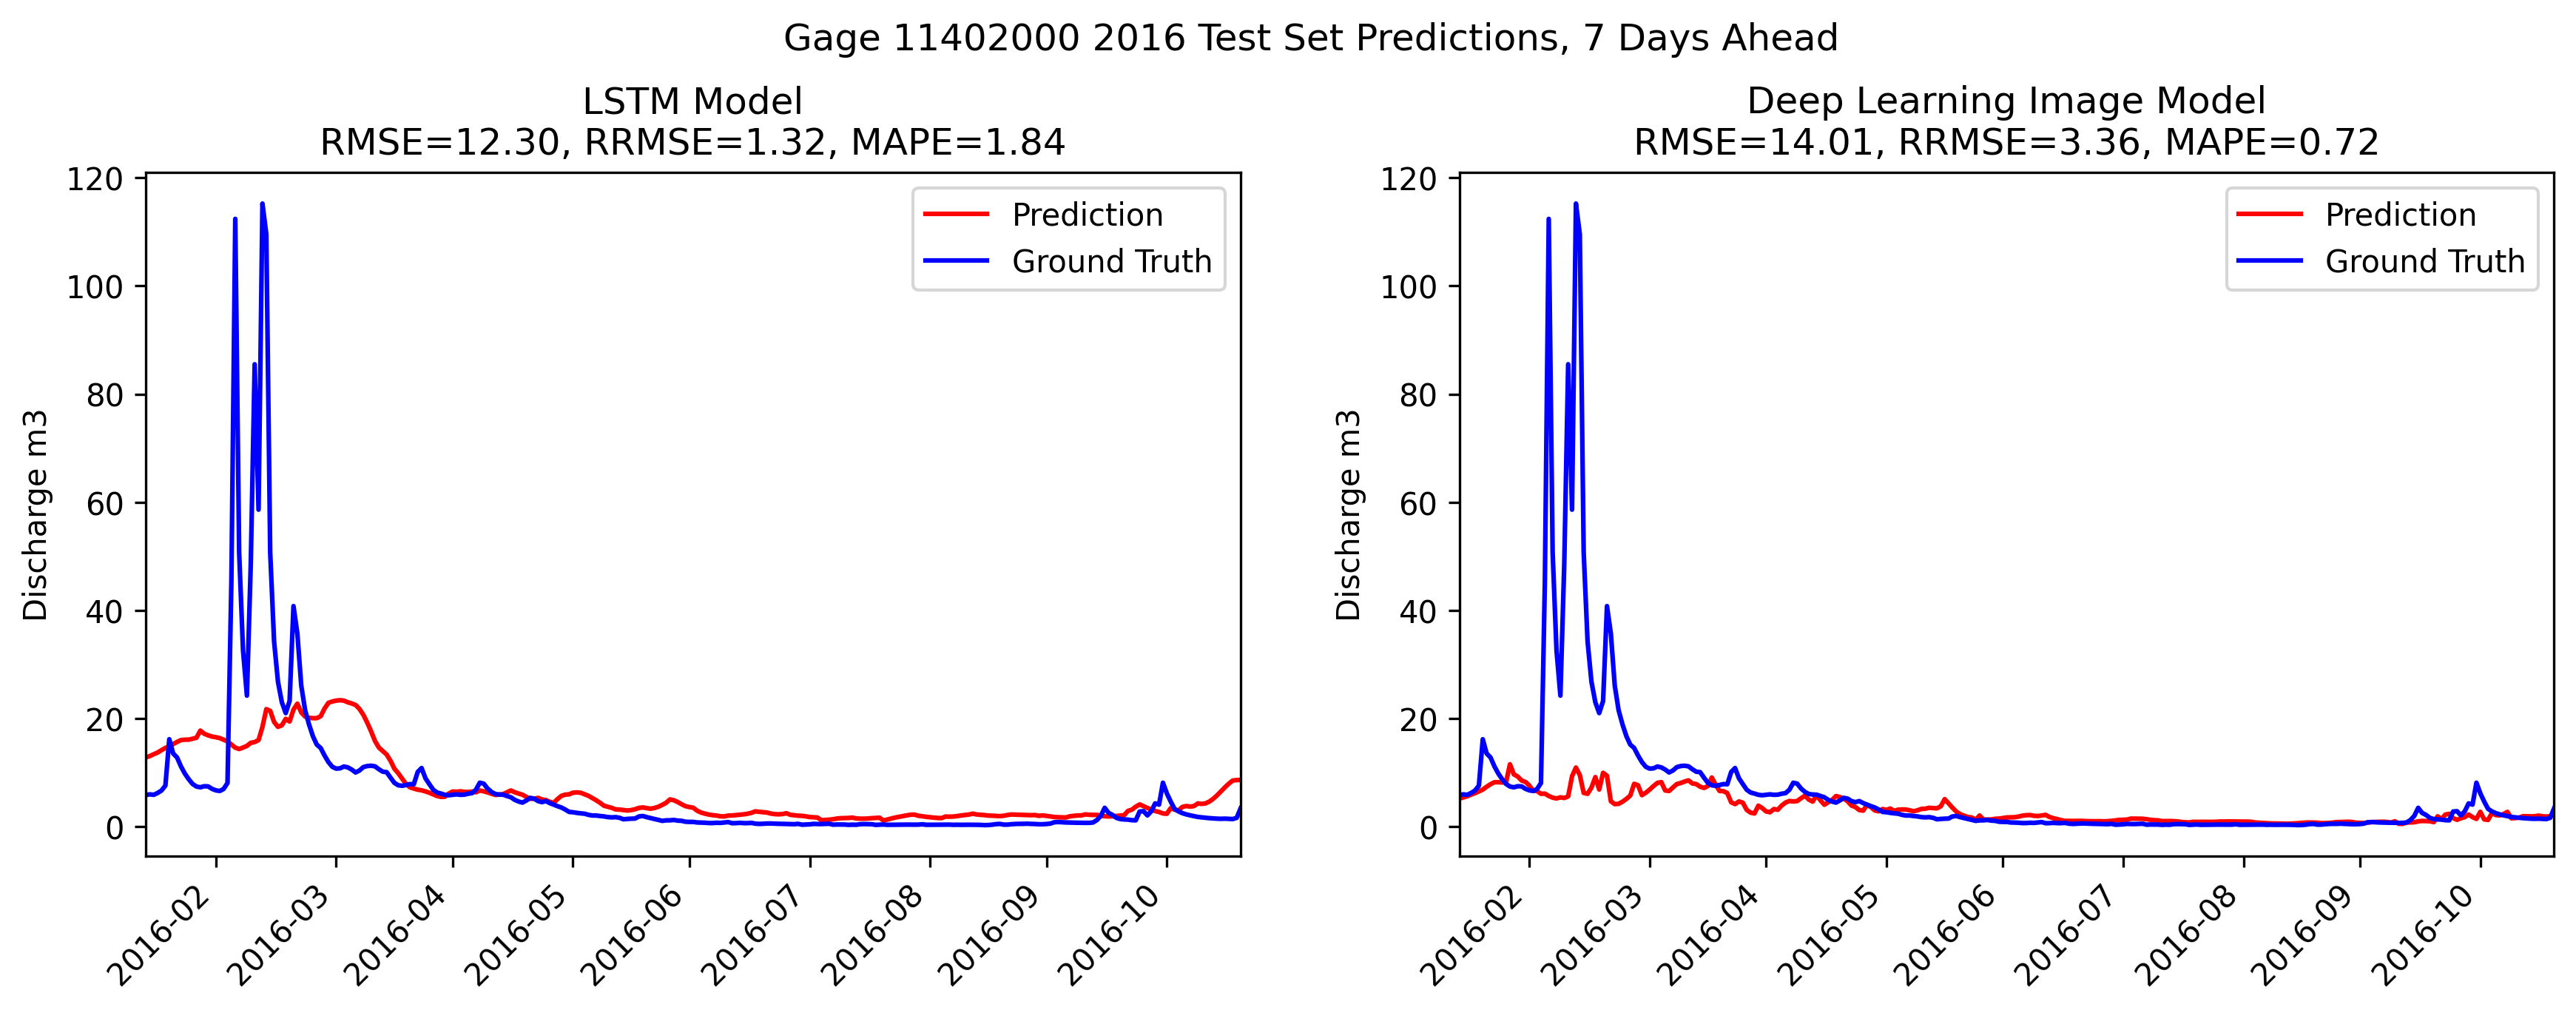

In [7]:
day = 7

sorted_results = single_gage_results.sort_values(by=[f"rmse_{day}day"])
exp_id = sorted_results.iloc[0]["id"]
print(exp_id)
expt = Experiment(exp_id)
expt.plot_test_pred_vs_lstm(day, dpi=300)

d9b5ad20-7179-42bc-b918-1c21949816b8
283


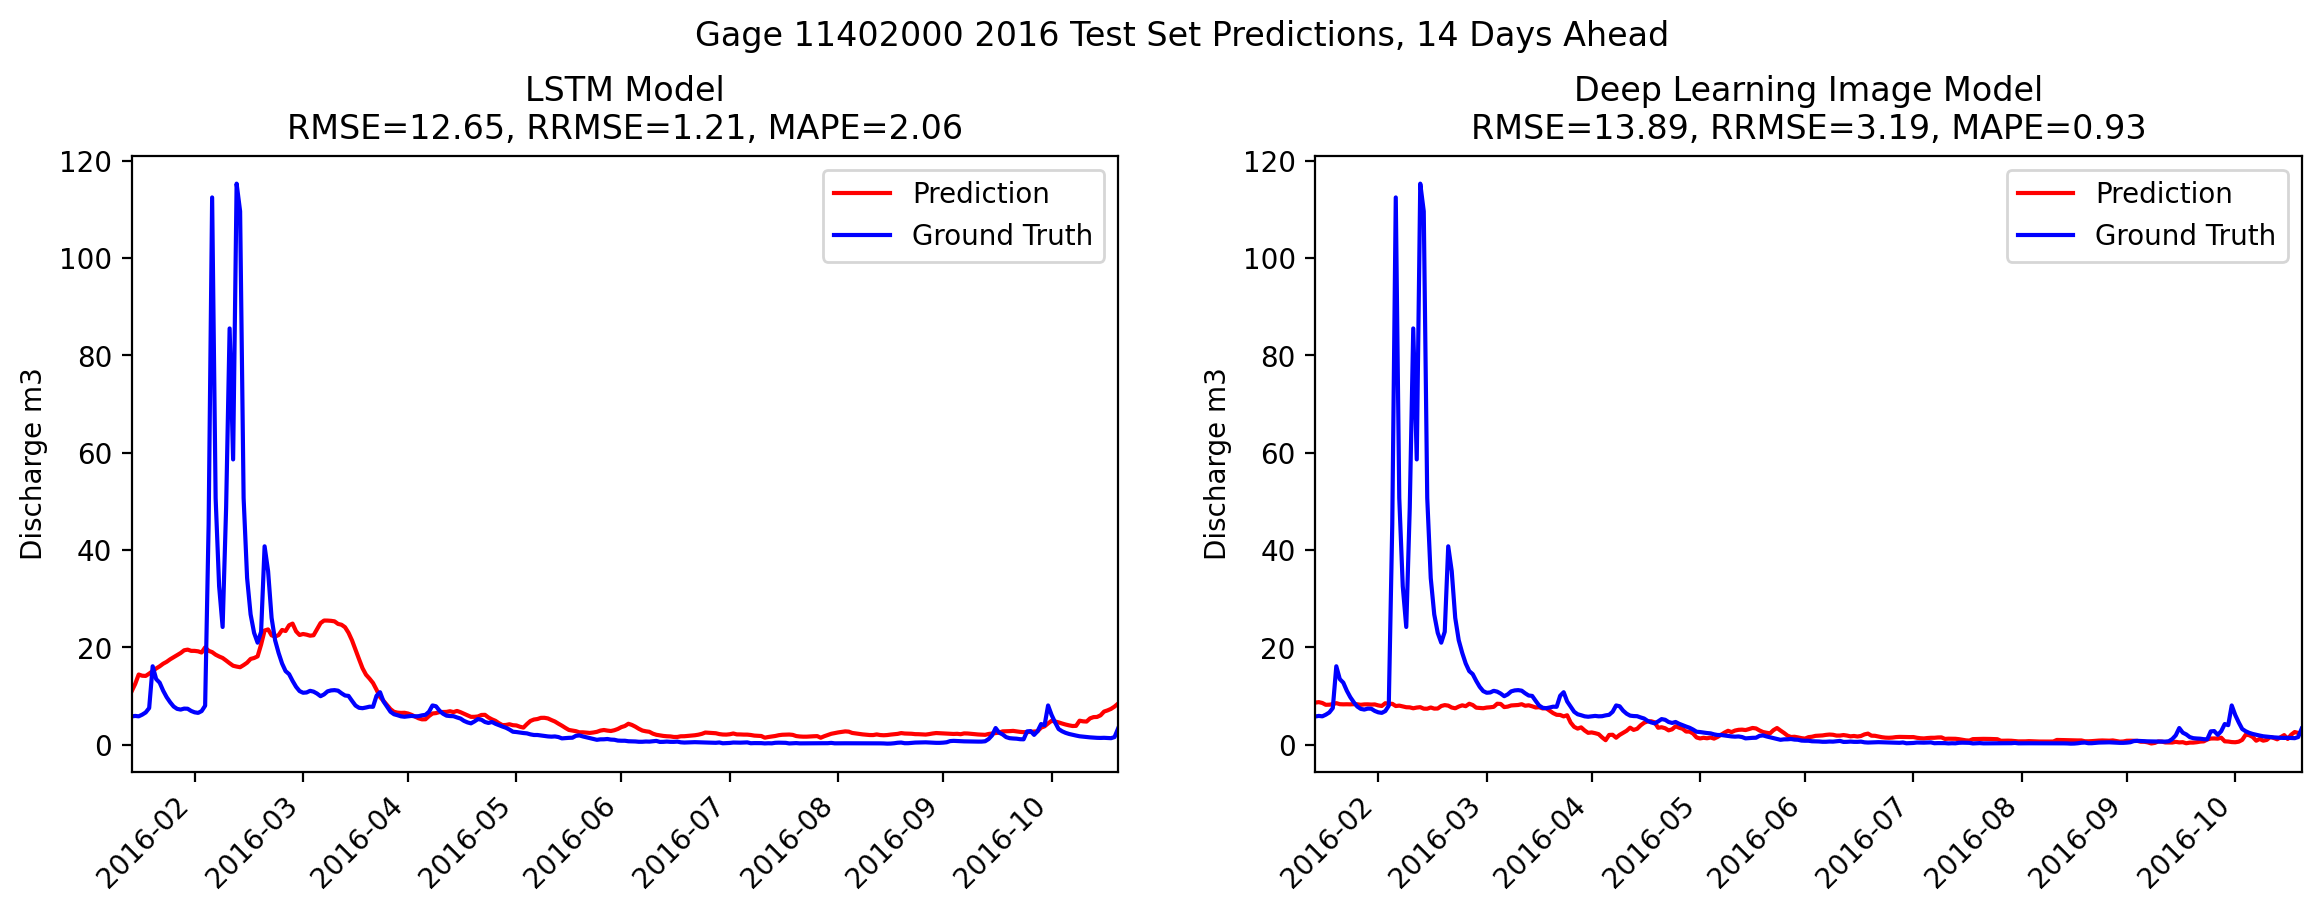

In [8]:
day = 14

sorted_results = single_gage_results.sort_values(by=[f"rmse_{day}day"])
exp_id = sorted_results.iloc[0]["id"]
print(exp_id)
expt = Experiment(exp_id)
expt.plot_test_pred_vs_lstm(day, dpi=200)

### 5-Gage results

In [9]:
multi_gage_results = results[results["gages"] == "['11402000', '11189500', '11318500', '11266500', '11202710']"]

53f1eb3c-4f34-4689-af6c-48ff79800de9
296


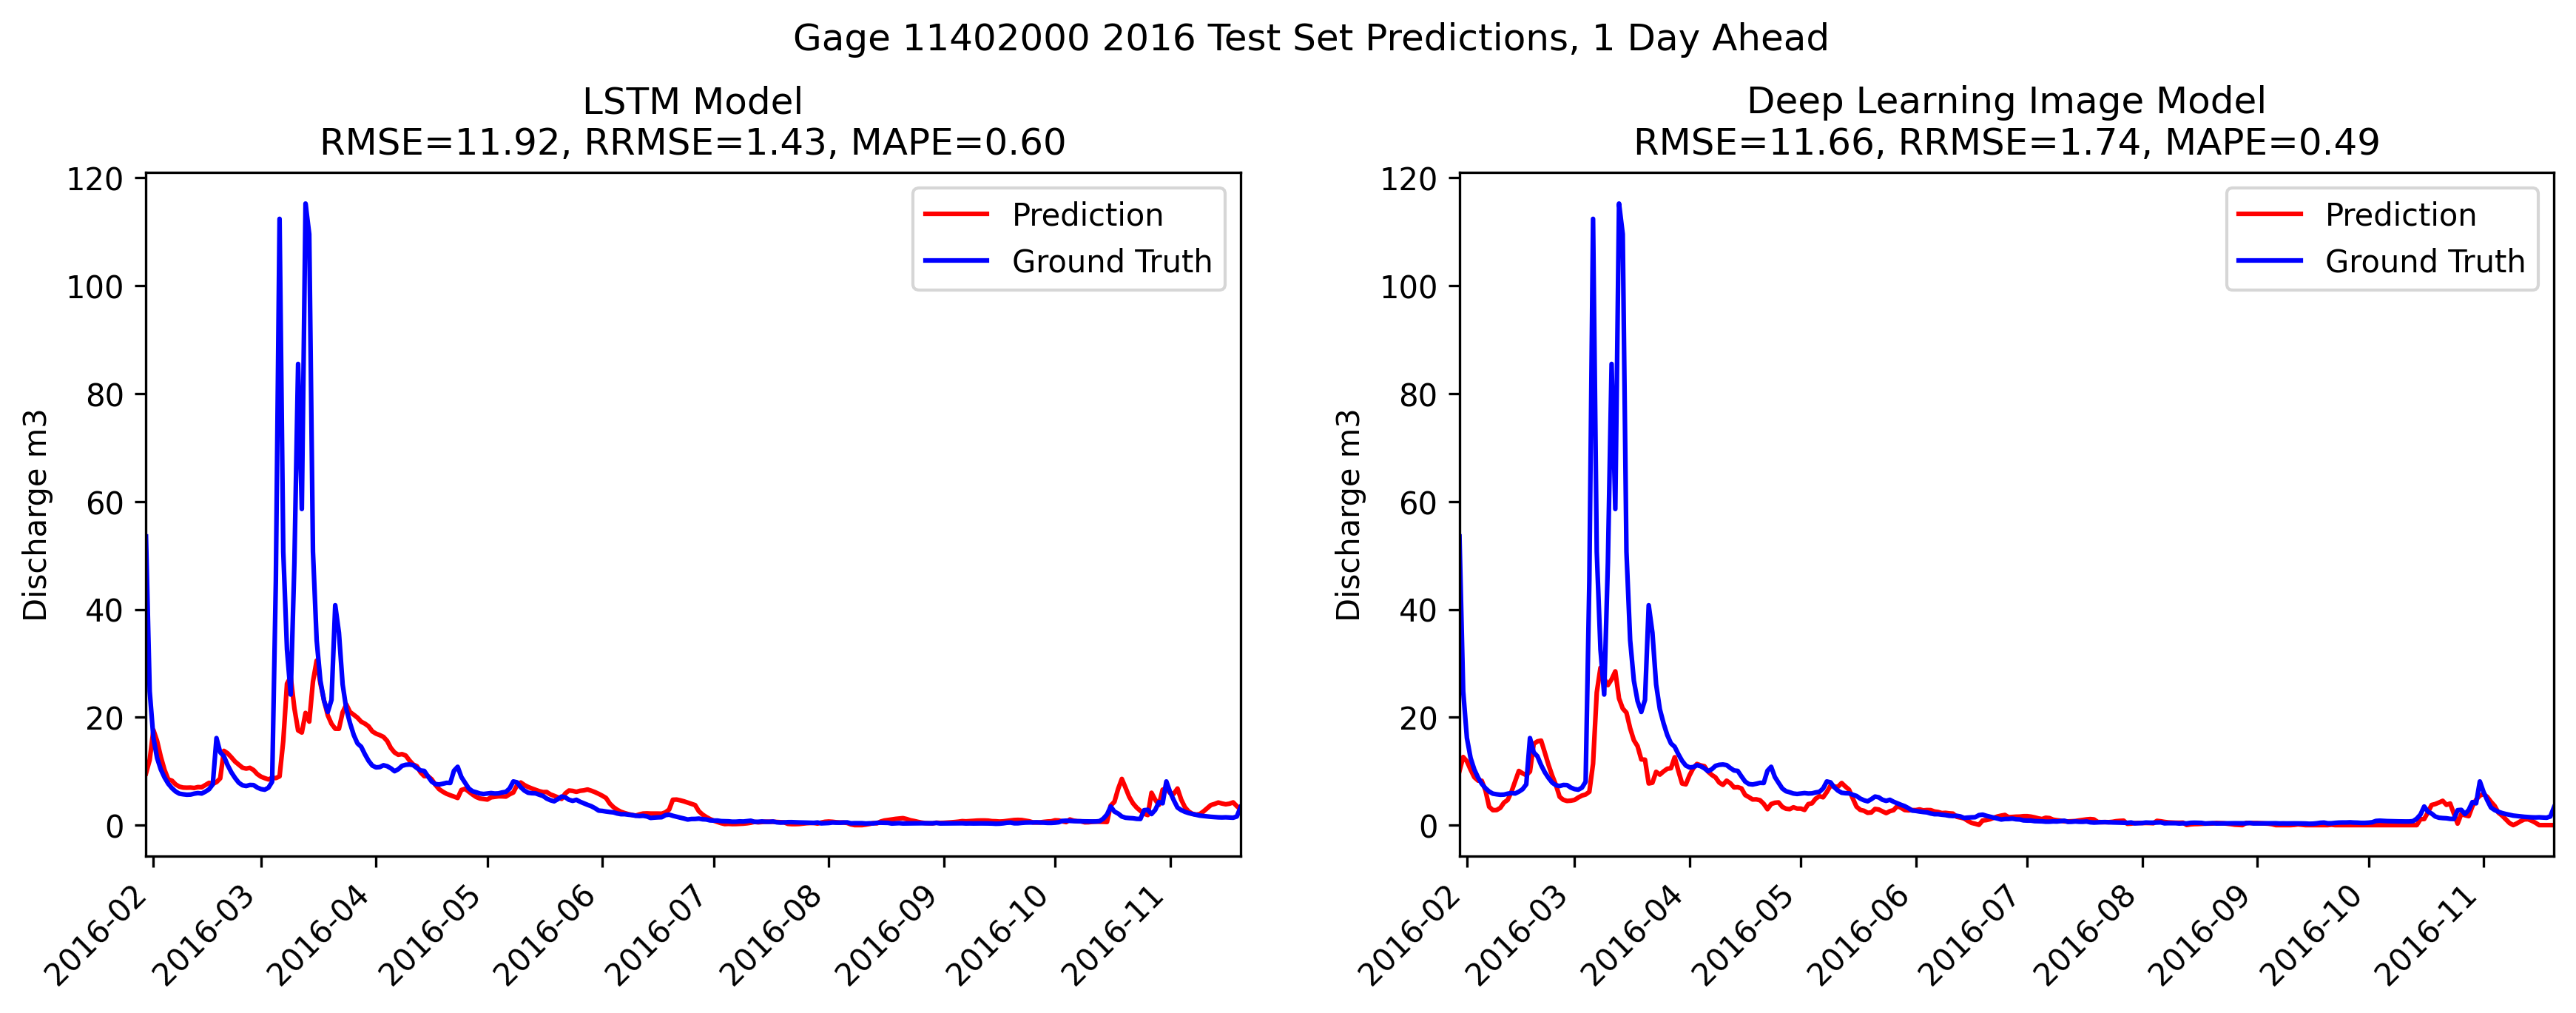

In [10]:
day = 1

sorted_results = multi_gage_results.sort_values(by=[f"rmse_{day}day"])
exp_id = sorted_results.iloc[0]["id"]
print(exp_id)
expt = Experiment(exp_id)
expt.plot_test_pred_vs_lstm(day, dpi=300)

efff4ffe-bf21-4cd6-a88d-a7e76c7e96ab
283


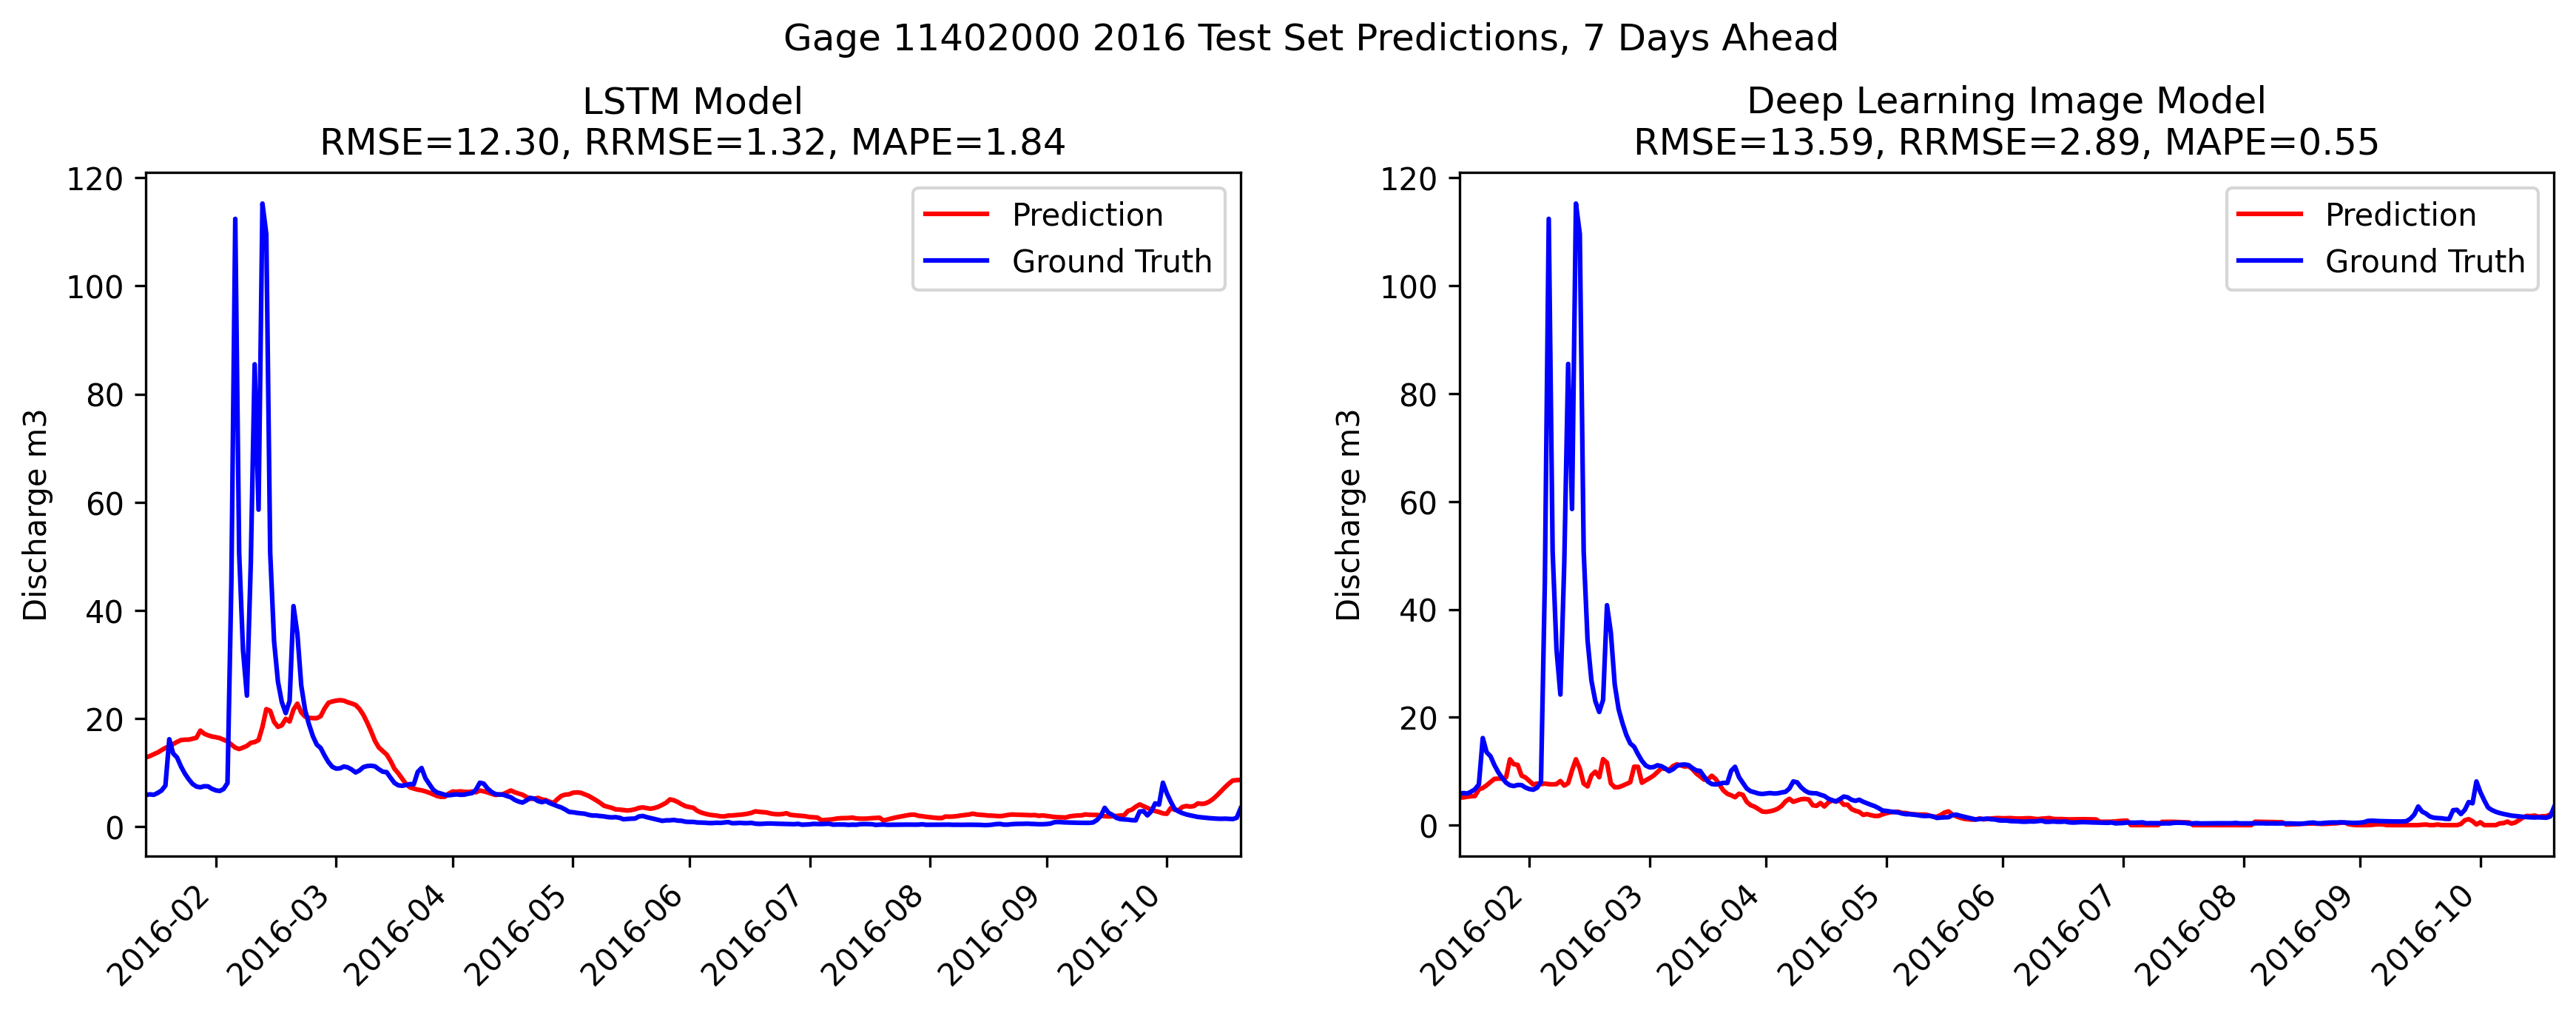

In [11]:
day = 7

sorted_results = multi_gage_results.sort_values(by=[f"rmse_{day}day"])
exp_id = sorted_results.iloc[0]["id"]
print(exp_id)
expt = Experiment(exp_id)
expt.plot_test_pred_vs_lstm(day, dpi=300)

efff4ffe-bf21-4cd6-a88d-a7e76c7e96ab
283


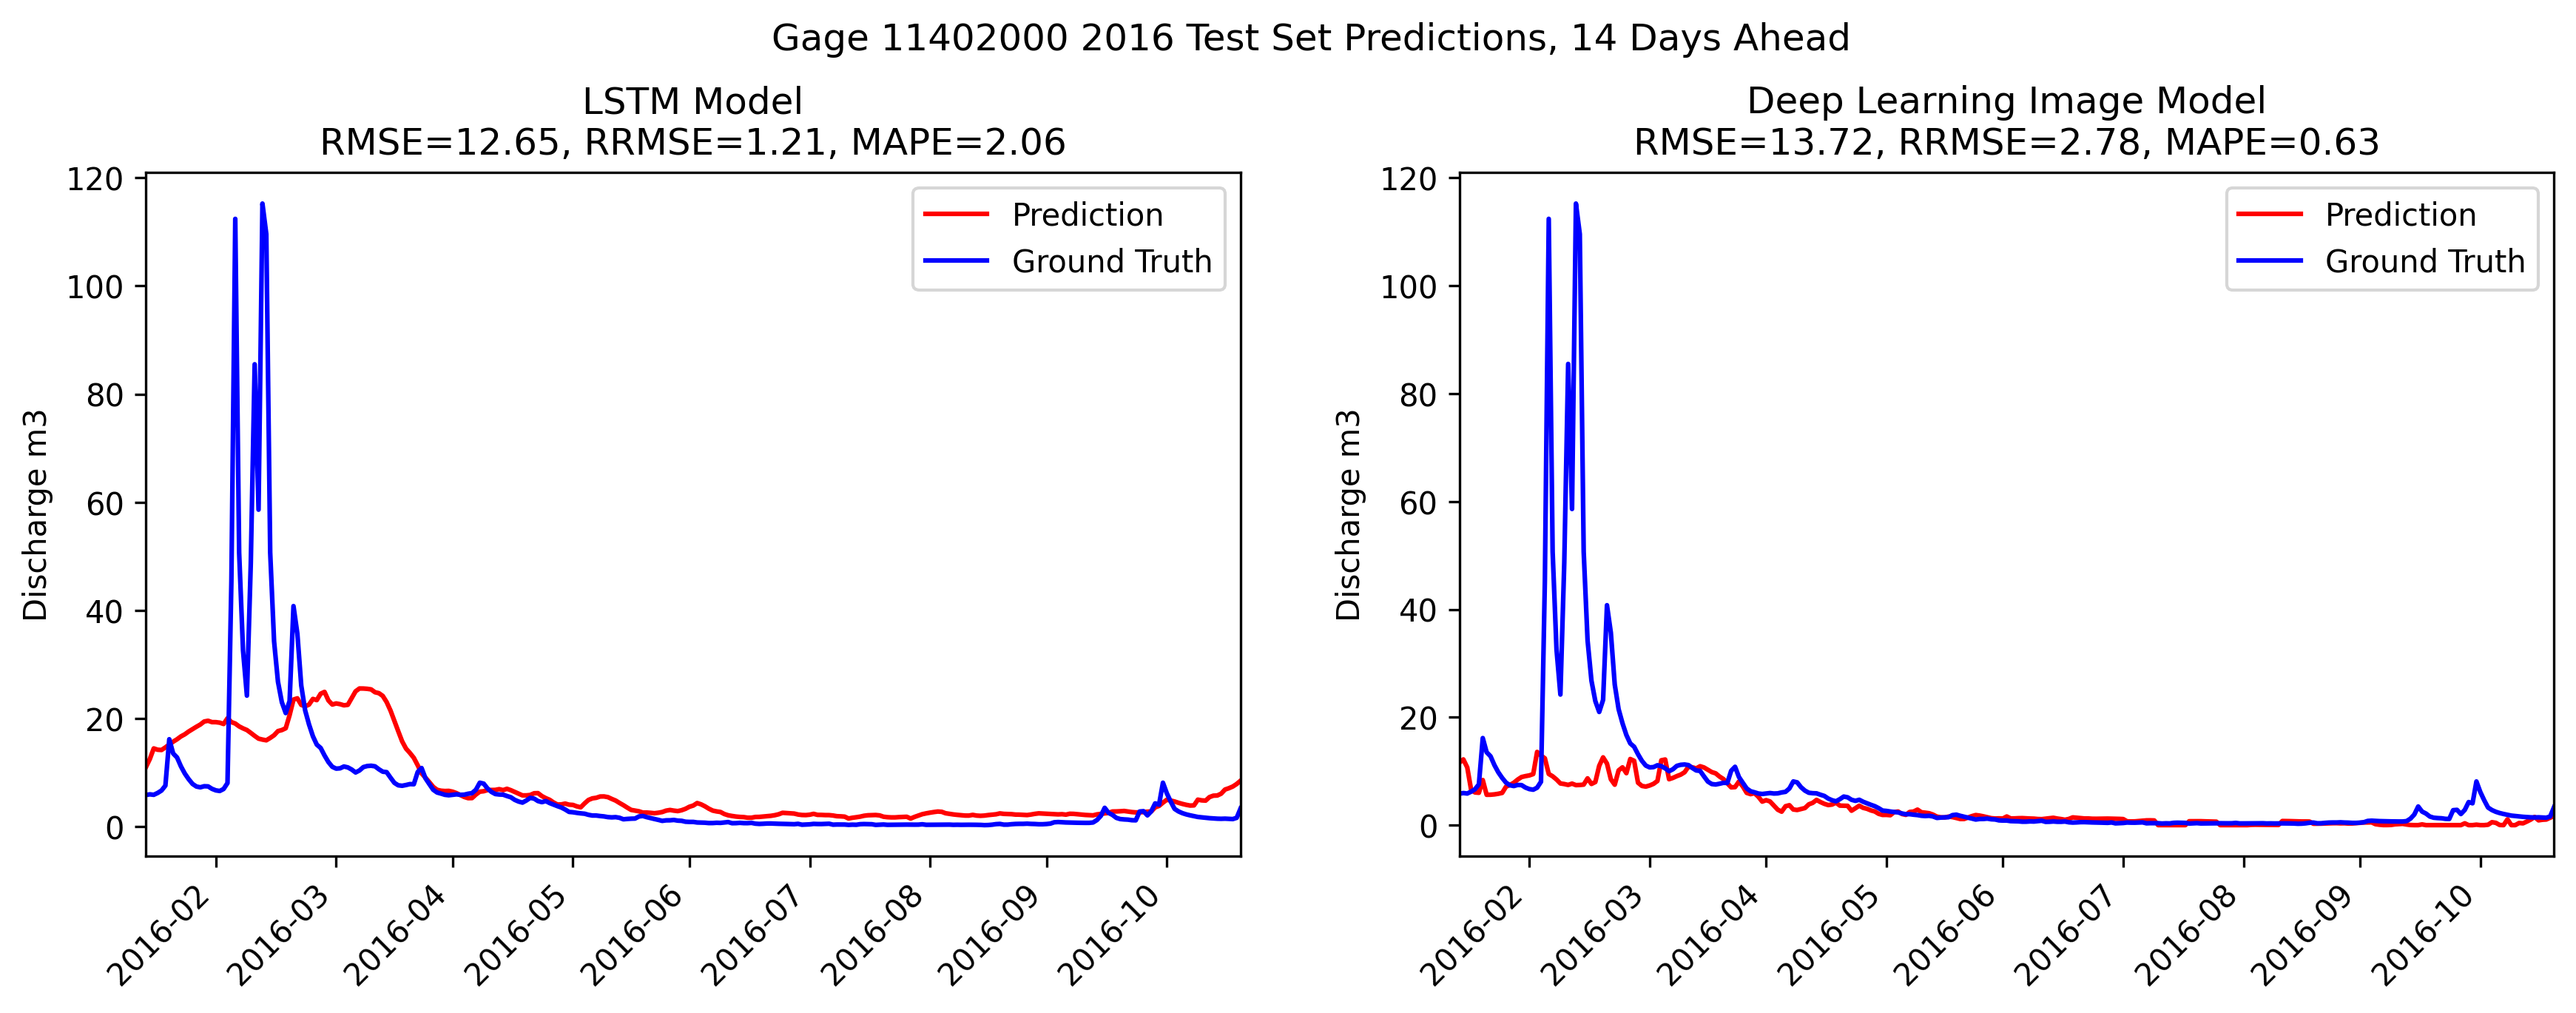

In [12]:
day = 14

sorted_results = multi_gage_results.sort_values(by=[f"rmse_{day}day"])
exp_id = sorted_results.iloc[0]["id"]
print(exp_id)
expt = Experiment(exp_id)
expt.plot_test_pred_vs_lstm(day, dpi=300)

#### Clearup

In [13]:
bad_experiments = exp_analysis.cleanup_bad_experiments()
bad_experiments

22 bad experiments contain some files so not deleted:
['0eb4d8cb-da78-4ec1-b95f-71fab6ac3f18', '1fbbf727-e1b1-4558-90f8-0cc87db425c3', '2d594519-15dd-464d-86e7-f6d5cee8053f', '37ca0d18-c0f8-4fd1-81a9-7a89f3017753', '3c6575c2-f476-4090-93e9-22b6a598b6f8', '3e9de5e8-b03e-4ba5-a0e5-10fc724abb9c', '3f260e4c-2d89-41b1-8f52-ec5282245b89', '40176a1f-8f1c-4b06-aa20-9ca26dd4aed4', '45009766-319c-47d9-8f67-f738e46472e9', '6dda2748-243a-411f-8a17-81a6065177eb', '888d08a2-629c-442c-82b3-3855f1f94de3', '909ca84b-cfba-409d-9d79-91ea3854362e', '95ad1867-3ab7-4f95-9da1-bdbacf9c6a8c', 'aeae58fc-05ab-4ede-b71f-29f7497d1e34', 'af714861-f0ab-421c-b618-6fdb702d6b0b', 'af79ed5c-0fb2-41b1-8b0e-53fe9b57a1d6', 'b1d31993-2fd4-4c2c-93bb-3afe84cc1798', 'bfbecb69-6517-40f8-aeff-d9b6eb685f3e', 'dff2c35e-0bf9-4d8f-b760-2744329dc8a2', 'f049cd9e-cfa4-4446-a1a8-c4ec2c9d8dcd', 'fac79eaa-08db-45af-822b-f65fdc27745d', 'ffa0f84f-1091-4b4c-bde6-b537168fb680']


['888d08a2-629c-442c-82b3-3855f1f94de3',
 '3c6575c2-f476-4090-93e9-22b6a598b6f8',
 'fac79eaa-08db-45af-822b-f65fdc27745d',
 'f049cd9e-cfa4-4446-a1a8-c4ec2c9d8dcd',
 '3e9de5e8-b03e-4ba5-a0e5-10fc724abb9c',
 'af79ed5c-0fb2-41b1-8b0e-53fe9b57a1d6',
 '2d594519-15dd-464d-86e7-f6d5cee8053f',
 'b1d31993-2fd4-4c2c-93bb-3afe84cc1798',
 '909ca84b-cfba-409d-9d79-91ea3854362e',
 'dff2c35e-0bf9-4d8f-b760-2744329dc8a2',
 'aeae58fc-05ab-4ede-b71f-29f7497d1e34',
 'bfbecb69-6517-40f8-aeff-d9b6eb685f3e',
 'ffa0f84f-1091-4b4c-bde6-b537168fb680',
 'af714861-f0ab-421c-b618-6fdb702d6b0b',
 '1fbbf727-e1b1-4558-90f8-0cc87db425c3',
 '6dda2748-243a-411f-8a17-81a6065177eb',
 '40176a1f-8f1c-4b06-aa20-9ca26dd4aed4',
 '95ad1867-3ab7-4f95-9da1-bdbacf9c6a8c',
 '3f260e4c-2d89-41b1-8f52-ec5282245b89',
 '37ca0d18-c0f8-4fd1-81a9-7a89f3017753',
 '45009766-319c-47d9-8f67-f738e46472e9',
 '0eb4d8cb-da78-4ec1-b95f-71fab6ac3f18']

## Full results

In [14]:
experiments = exp_analysis.save_best_predictions()

Predictions saved to: /tf/toby/discharge-estimation/models/../data/best_model_rmse_day1_test_pred.csv
Predictions saved to: /tf/toby/discharge-estimation/models/../data/best_model_rmse_day7_test_pred.csv
Predictions saved to: /tf/toby/discharge-estimation/models/../data/best_model_rmse_day14_test_pred.csv


In [16]:
results = exp_analysis.save_full_results()
results

Predictions saved to: /tf/toby/discharge-estimation/models/../data/best_model_rmse_day1_test_pred.csv
Predictions saved to: /tf/toby/discharge-estimation/models/../data/best_model_rmse_day7_test_pred.csv
Predictions saved to: /tf/toby/discharge-estimation/models/../data/best_model_rmse_day14_test_pred.csv


,true_mu,true_std,1day_pred_mu,1day_pred_std,1day_rmse,1day_mape,1day_rrmse,7day_pred_mu,7day_pred_std,7day_rmse,7day_mape,7day_rrmse,14day_pred_mu,14day_pred_std,14day_rmse,14day_mape,14day_rrmse
gage,,,,,,,,,,,,,,,,,
11402000,7.729216,14.798042,4.851952,6.214563,11.607875,0.604149,1.473531,3.643602,3.742620,13.730399,0.614104,2.630593,3.874046,3.981984,13.547488,0.643548,2.440320
11189500,0.644654,0.751618,1.874699,2.550068,2.426029,9.931006,0.767196,1.201382,2.265074,1.805985,12.782584,0.705156,1.794642,2.731095,2.486081,12.579837,0.761498
11318500,1.834101,3.099809,1.892266,2.362815,2.513576,2.051635,0.831041,1.229608,1.800812,2.775407,2.258421,1.274028,1.250881,1.809593,2.715475,2.193792,1.235580
11266500,21.027563,23.518381,12.128512,13.828873,16.085360,0.669839,0.875168,11.588438,13.782244,17.055919,0.607232,0.947986,12.144736,13.565333,17.212216,0.696743,0.946083
11202710,1.122939,1.539005,1.513654,1.930229,1.935303,1.628693,0.789642,1.193272,1.354491,1.597098,1.422020,0.885457,1.430780,1.491705,1.746983,1.805896,0.845821
